# Video Processing with Object Segmentation and Style Transfer

Antonin Wattel, Pierre Pages

In [1]:
#https://stackoverflow.com/questions/40088222/ffmpeg-convert-video-to-images
#see this for ffmpeg for python

explain how to run, dependencies etc...

In [2]:
import os
import importlib.util
import sys
import numpy as np #NEEDED ?
import matplotlib.pyplot as plt
import cv2
from IPython.display import Video

In [3]:
#current working directory (this should be the base directory of the project)
CWD = os.getcwd()

#to import modules
def module_from_file(module_name, file_path):
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module

# 1. Video Choice
The first thing to do is to choose out video to be processed. The longer it lasts, and the greater the resolution is, the longer the process will take.

## Custom choice 

If you want to use a preprocesed video, skip this part.

### Loading the video

In [40]:
#choose an mp4 video and place it in the unprocessed_videos folder
#set seq_name to the video name (without .mp4 extension)
#avoid spaces in the video name

seq_name = 'skate_sage_elsesser'
video_path = os.path.join(CWD, 'unprocessed_videos/{}.mp4'.format(seq_name))

In [5]:
#visualize video
Video('unprocessed_videos/{}.mp4'.format(seq_name))

### Trimming the video 

The longer the video is, the longer the process, so keeping a video of only a few seconds is good

In [77]:
#choose timecodes for trimming
time1 = '00:00:17.8'
time2 = '00:00:24'
output_path = os.path.join(CWD, 'unprocessed_videos', '{}_trimmed.mp4'.format(seq_name))
#command = '! ffmpeg -i {} -ss {} -to {} -c copy {} -y'.format(video_path, time1, time2, output_path)
command = '! ffmpeg -i {} -ss {} -to {} {} -y'.format(video_path, time1, time2, output_path)
print(command)

! ffmpeg -i c:\Users\A1234\Documents\INF573\project\unprocessed_videos/skate_sage_elsesser.mp4 -ss 00:00:17.8 -to 00:00:24 c:\Users\A1234\Documents\INF573\project\unprocessed_videos\skate_sage_elsesser_trimmed.mp4 -y


In [60]:
%%capture 
#paste the above output and run
! ffmpeg -i c:\Users\A1234\Documents\INF573\project\unprocessed_videos/skate_sage_elsesser.mp4 -ss 00:00:18 -to 00:00:24 c:\Users\A1234\Documents\INF573\project\unprocessed_videos\skate_sage_elsesser_trimmed.mp4 -y

In [61]:
#visualize trimmed video
Video('unprocessed_videos/{}_trimmed.mp4'.format(seq_name))

### Conversion to image sequence

In [78]:
#now convert the mp4 into a sequence of images, and put this sequence in the appropriate folder, ready to be processed
input_video = output_path
output_sequence = os.path.join(CWD, 'OSVOS-PyTorch/DAVIS-data/DAVIS/JPEGImages/480p/{}'.format(seq_name))
if not os.path.exists(output_sequence):
    os.makedirs(output_sequence)

command = '! ffmpeg  -i {} -qscale:v 2 -start_number 0 {}/%05d.jpg -y'.format(input_video, output_sequence)
print(command)

! ffmpeg  -i c:\Users\A1234\Documents\INF573\project\unprocessed_videos\skate_sage_elsesser_trimmed.mp4 -qscale:v 2 -start_number 0 c:\Users\A1234\Documents\INF573\project\OSVOS-PyTorch/DAVIS-data/DAVIS/JPEGImages/480p/skate_sage_elsesser/%05d.jpg -y


In [79]:
%%capture
#paste the above output and run
! ffmpeg  -i c:\Users\A1234\Documents\INF573\project\unprocessed_videos\skate_sage_elsesser_trimmed.mp4 -qscale:v 2 -start_number 0 c:\Users\A1234\Documents\INF573\project\OSVOS-PyTorch/DAVIS-data/DAVIS/JPEGImages/480p/skate_sage_elsesser/%05d.jpg -y

### Masking

Now that we have the sequence of images, we need to have a mask of the object we want to segment for the first image

- Method 1 : use external software 

In [80]:
#Manually create the mask of the first image of the sequence with a software (photoshop, gimp...) and save it as 00000.png in the followig folder

mask_path = os.path.join(CWD, 'OSVOS-PyTorch/DAVIS-data/DAVIS/Annotations/480p/{}'.format(seq_name))
if not os.path.exists(mask_path):
    os.makedirs(mask_path)

print(mask_path)

c:\Users\A1234\Documents\INF573\project\OSVOS-PyTorch/DAVIS-data/DAVIS/Annotations/480p/skate_sage_elsesser


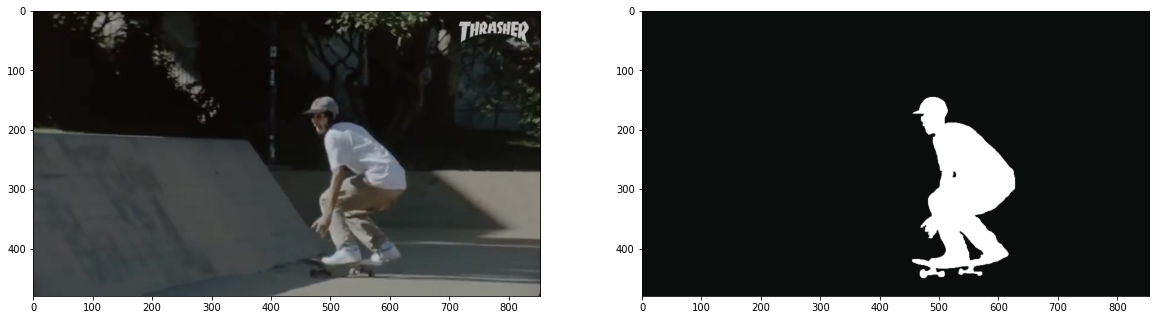

In [81]:
#check it looks good
plt.figure(figsize =(20, 10))
original_image = cv2.imread(os.path.join(output_sequence, '00000.jpg'))
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
mask_image = cv2.imread(os.path.join(mask_path, '00000.png'))

plt.subplot(1, 2, 1)
plt.imshow(original_image)

plt.subplot(1, 2, 2)
plt.imshow(mask_image)

plt.show()

* Method 2 : Foreground extraction using GrabCut Algorithm

https://docs.opencv.org/4.x/d8/d83/tutorial_py_grabcut.html

to be improved by manually marking the mask image

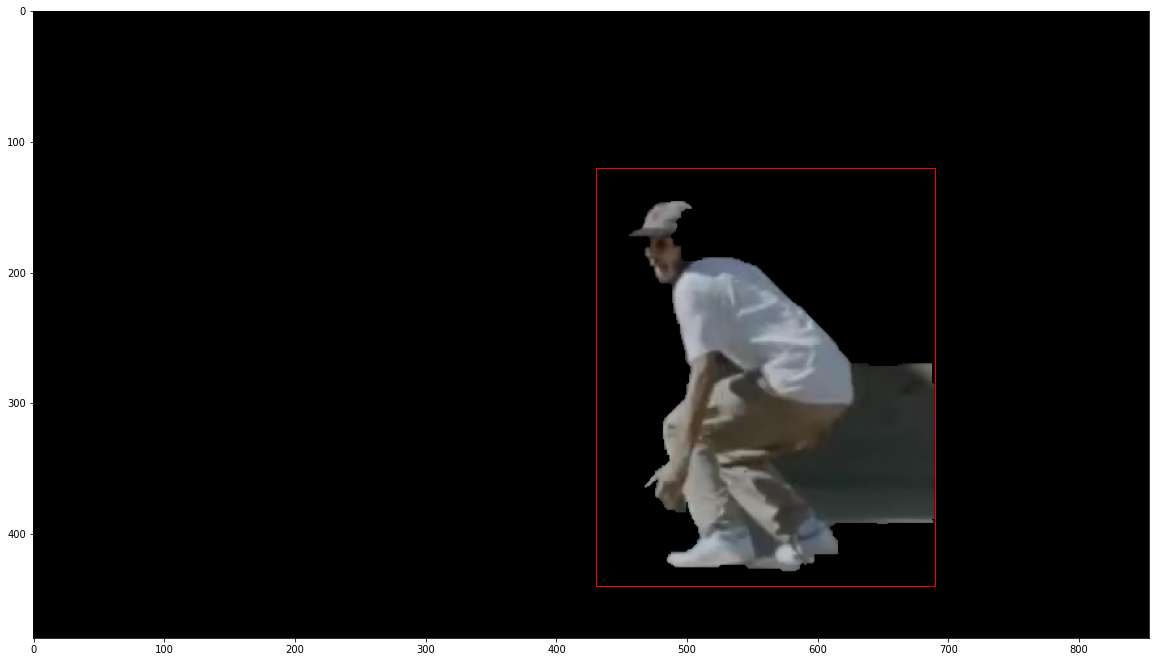

In [82]:
#play with the reclangle coordinates to have a good mask
#(rq: this will work well will well defined/contrasted foreground/background)

from matplotlib.patches import Rectangle

img =  cv2.imread(os.path.join(output_sequence, '00000.jpg'))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = np.zeros(img.shape[:2],np.uint8)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

rect = (430,120,260,320)

fig, ax = plt.subplots(figsize = (20, 20))
plt.gca().add_patch(Rectangle((rect[0], rect[1]), rect[2], rect[3], edgecolor='red', facecolor='none', lw=1))

cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)

mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]

ax.imshow(img)
plt.show()

## Preprocessed video

The DAVIS dataset already provides short videos put into sequences of images, as well as the associated masks.

In [258]:
#we can use preprocessed videos from the validation set (choose among the following)

# blackswan, bmx-trees, breakdance, camel, car-roundabout,
# car-shadow, cows, dance-twirl, dog, drift-chicane, 
# drift-straight, goat, horsejump-high, kite-surf,
# libby, motocross-jump, paragliding-launch, parkour, 
# scooter-black, soapbox

seq_name = 'dance-twirl'

In [259]:
# Make video out of sequence (for demonstration)

data_path = 'OSVOS-PyTorch/DAVIS-data/DAVIS/JPEGImages/480p/{} '.format(seq_name)
out_path = os.path.join(CWD, 'Results/in_videos/{}.mp4'.format(seq_name))
command = '! cd {} & ffmpeg -r 25 -f image2 -s 720*480 -i %05d.jpg -vcodec libx264 -crf 25  -pix_fmt yuv420p -y {}'.format(data_path, out_path)
print(command)


! cd OSVOS-PyTorch/DAVIS-data/DAVIS/JPEGImages/480p/dance-twirl  & ffmpeg -r 25 -f image2 -s 720*480 -i %05d.jpg -vcodec libx264 -crf 25  -pix_fmt yuv420p -y c:\Users\A1234\Documents\INF573\project\Results/in_videos/dance-twirl.mp4


In [260]:
%%capture 
#paste the above output and run
! cd OSVOS-PyTorch/DAVIS-data/DAVIS/JPEGImages/480p/dance-twirl  & ffmpeg -r 25 -f image2 -s 720*480 -i %05d.jpg -vcodec libx264 -crf 25  -pix_fmt yuv420p -y c:\Users\A1234\Documents\INF573\project\Results/in_videos/dance-twirl.mp4

In [261]:
Video('Results/in_videos/{}.mp4'.format(seq_name))

# 2. Object segmentation

The object segmentaion is based on the PyTorch implementation of One-Shot Video Object Segmentation (OSVOS)
https://github.com/kmaninis/OSVOS-PyTorch.
<br/>
We use a pretrained parent model, available at https://data.vision.ee.ethz.ch/kmaninis/share/OSVOS/Downloads/models/pth_parent_model.zip.

In [83]:
#import from other files
sys.path.append(os.path.join(CWD, 'OSVOS-Pytorch'))
train_path = os.path.join(CWD, 'OSVOS-Pytorch', 'train_online.py')
train_online = module_from_file("train_online", train_path)

In [114]:
#a few training parameters
#for more parameters, see OSVOS-Pytorch/train_online.py

seq_name=seq_name
save_dir_res= os.path.join(CWD, 'Results', 'masks', seq_name, 'sequences')
nAveGrad=5
nEpochs= 5000 * nAveGrad #the more epochs we take, the better the segementation results

train_online.train(seq_name, save_dir_res, nAveGrad, nEpochs)
print('done')

gpu device =  cuda:0
Constructing OSVOS architecture..
Initializing weights..
Done initializing train_seqs Dataset
Done initializing val_seqs Dataset
Start of Online Training, sequence: skate_sage_elsesser
nEpochs:  25000
[Epoch: 1250, numImages:     1]
Loss: 991.029175


In [111]:
res_path = 'Results/masks/{}/sequences'.format(seq_name)
out_path = os.path.join(CWD, 'Results/in_videos/{}.mp4'.format(seq_name))
command = '! cd {} & ffmpeg -r 25 -f image2 -s 720*480 -i %05d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p -y mask_video.mp4'.format(res_path)
print(command)

! cd Results/masks/skate_sage_elsesser/sequences & ffmpeg -r 25 -f image2 -s 720*480 -i %05d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p -y mask_video.mp4


In [112]:
%%capture 
#paste the above output and run
! cd Results/masks/skate_sage_elsesser/sequences & ffmpeg -r 25 -f image2 -s 720*480 -i %05d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p -y mask_video.mp4

In [113]:
Video("Results/masks/{}/sequences/mask_video.mp4".format(seq_name))

# 2. Style transfer

This part is based on the PyTorch implementation https://github.com/rrmina/fast-neural-style-pytorch following the style transfer approach outlined in Perceptual Losses for Real-Time Style Transfer and Super-Resolution paper by Justin Johnson, Alexandre Alahi, and Fei-Fei Li, along with the supplementary paper detailing the exact model architecture of the mentioned paper.

In [4]:
#import files
sys.path.append(os.path.join(CWD, 'fast-neural-style-pytorch'))

train_path = os.path.join(CWD, 'fast-neural-style-pytorch', 'train.py')
style_train = module_from_file("train", train_path)

stylize_path = os.path.join(CWD, 'fast-neural-style-pytorch', 'stylize.py')
stylize = module_from_file("stylize", stylize_path)


## Training style transfer network
This step will take some time to run.
You can alternatively use pretrained models (see next step)

We train the models on a portion (2000 images) of the coco2014 dataset, available at https://cocodataset.org/#download.<br/>
The training dataset must be placed in the folder fast-neural-style-pytorch/data. </br>
<br/>
This model is trained on the pretrained vgg model available at https://web.eecs.umich.edu/~justincj/models/vgg16-00b39a1b.pth. <br/>
This model must be placed in fast-neural-style-pytorch/models

Here, we use a TransformerNetwrok (see transformer.py for architecture).
Some other experimental transformer architectures can be tested (see experimental.py)

* Choice of style image

In [5]:
#choose an image to train the style on
#in the folder images, we provide a few images for the style
#To choose your own, choose a jpg image and place it in the fast-neural-style-pytorch/images folder
#careful: too large images will lead to long training times

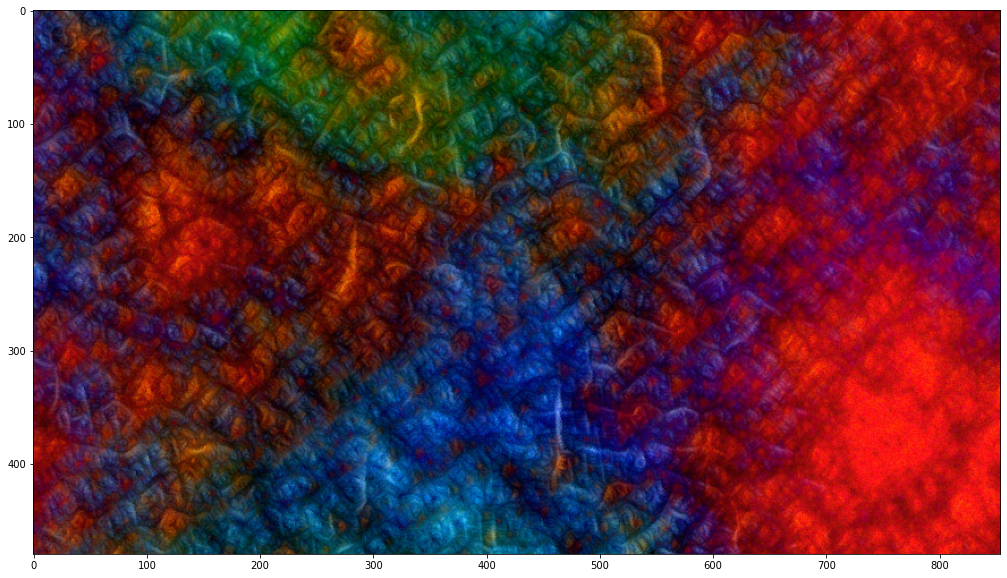

In [6]:
style_image_name = 'multicolor' # (this is an image made with 'Vision of Chaos' software)
style_image_path = os.path.join(CWD, 'fast-neural-style-pytorch', 'images', '{}.jpg'.format(style_image_name))

style_image = cv2.imread(style_image_path)
style_image = cv2.cvtColor(style_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20, 10))
plt.imshow(style_image)
plt.show()

In [7]:
num_epochs = 200
dataset_path = os.path.join(CWD, 'fast-neural-style-pytorch', 'data', 'train2014' )#to fill
style_image_path = os.path.join(CWD, 'fast-neural-style-pytorch', 'images', '{}.jpg'.format(style_image_name))
save_checkpoints_path = os.path.join(CWD, 'fast-neural-style-pytorch', 'models')
save_model_path_final = os.path.join(CWD, 'fast-neural-style-pytorch', 'transforms', '{}.pth'.format(style_image_name))
save_image_path = os.path.join(CWD, 'fast-neural-style-pytorch', 'images/out')
save_model_every = 500
plt_loss = 1
show_images = 1

args = [num_epochs, dataset_path, style_image_path, save_checkpoints_path, save_model_path_final, save_image_path, save_model_every, plt_loss, show_images]
style_train.train(args)

c:\Users\A1234\Documents\INF573\project
device =  cuda:0
CWD: c:\Users\A1234\Documents\INF573\project
========Epoch 1/200========
========Iteration 1/14200========
	Content Loss:	2479959.50
	Style Loss:	68304384.00
	Total Loss:	70784344.00
Time elapsed:	2.372102975845337 seconds
Saved sample tranformed image at c:\Users\A1234\Documents\INF573\project\fast-neural-style-pytorch\modelssample0_0.png
========Epoch 2/200========
========Epoch 3/200========
========Epoch 4/200========
========Epoch 5/200========
========Epoch 6/200========
========Epoch 7/200========
========Epoch 8/200========
========Iteration 501/14200========
	Content Loss:	3295758.25
	Style Loss:	9388675.56
	Total Loss:	12684433.87
Time elapsed:	296.52988028526306 seconds
Saved sample tranformed image at c:\Users\A1234\Documents\INF573\project\fast-neural-style-pytorch\modelssample0_500.png
========Epoch 9/200========
========Epoch 10/200========
========Epoch 11/200========
========Epoch 12/200========
========Epoch 13/

## Pretrained style transfer models
You can choose among the follwowing pretrained styles.


In [142]:
#see README inside fast-neural-style-pytorch/transforms for more pretrained + experimental models

# As seen on https://github.com/rrmina/fast-neural-style-pytorch
# bayanihan, lazy, mosaic, starry, 
# tokyo_ghoul, udnie, wave, mosaic_TransformerResNetwork

# I also trained the following
# multicolor


In [91]:
#run this cell to use a pretrained model of your choice

style_image_name = 'multicolor'

## Styling videos
We style images one by one

In [92]:
style_model_foreground =  None
style_model_background = None

### Foreground

In [93]:
style_model_foreground = 'wave'
style_path_foreground = os.path.join(CWD, 'fast-neural-style-pytorch/transforms/{}.pth'.format(style_model_foreground))
preserve_color = False

In [94]:
content_folder = os.path.join(CWD, 'OSVOS-PyTorch/DAVIS-data/DAVIS/JPEGImages/480p/{}'.format(seq_name))
save_folder = os.path.join(CWD,'Results/stylized/{}/{}'.format(seq_name, style_model_foreground))
#create the folders if they don't exist 

if not os.path.exists(save_folder):
    os.makedirs(save_folder)

if style_model_foreground is not None:
    stylize.stylize_folder_single(style_path_foreground, content_folder , save_folder, preserve_color)

print('done')

device:  cuda:0
done


In [95]:
#save and play the video

if style_model_foreground is not None:
    res_path = save_folder
    command = '! cd {} & ffmpeg -r 25 -f image2 -s 720*480 -i %05d.jpg -vcodec libx264 -crf 25  -pix_fmt yuv420p -y video.mp4'.format(res_path)
    print(command)


! cd c:\Users\A1234\Documents\INF573\project\Results/stylized/skate_sage_elsesser/wave & ffmpeg -r 25 -f image2 -s 720*480 -i %05d.jpg -vcodec libx264 -crf 25  -pix_fmt yuv420p -y video.mp4


In [96]:
%%capture
#paste previous line here
! cd c:\Users\A1234\Documents\INF573\project\Results/stylized/skate_sage_elsesser/wave & ffmpeg -r 25 -f image2 -s 720*480 -i %05d.jpg -vcodec libx264 -crf 25  -pix_fmt yuv420p -y video.mp4

### Background

In [198]:
style_model_background = 'pointillism'
style_path_foreground = os.path.join(CWD, 'fast-neural-style-pytorch/transforms/{}.pth'.format(style_model_background))
preserve_color = False

In [157]:
content_folder = os.path.join(CWD, 'OSVOS-PyTorch/DAVIS-data/DAVIS/JPEGImages/480p/{}'.format(seq_name))
save_folder = os.path.join(CWD,'Results/stylized/{}/{}'.format(seq_name, style_model_background))
#create the folders if they don't exist 
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

if style_model_background is not None:
    stylize.stylize_folder_single(style_path_foreground, content_folder , save_folder, preserve_color)

device:  cuda:0


In [158]:
#save and play the video

if style_model_background is not None:
    res_path = save_folder
    command = '! cd {} & ffmpeg -r 25 -f image2 -s 720*480 -i %05d.jpg -vcodec libx264 -crf 25  -pix_fmt yuv420p -y video.mp4'.format(res_path)
    print(command)



! cd c:\Users\A1234\Documents\INF573\project\Results/stylized/House_dance/pointillism & ffmpeg -r 25 -f image2 -s 720*480 -i %05d.jpg -vcodec libx264 -crf 25  -pix_fmt yuv420p -y video.mp4


In [159]:
#paste previous line here
! cd c:\Users\A1234\Documents\INF573\project\Results/stylized/House_dance/pointillism & ffmpeg -r 25 -f image2 -s 720*480 -i %05d.jpg -vcodec libx264 -crf 25  -pix_fmt yuv420p -y video.mp4

ffmpeg version n4.4.1-2-gcc33e73618-20211210 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11.2.0 (crosstool-NG 1.24.0.498_5075e1f)
  configuration: --prefix=/ffbuild/prefix --pkg-config-flags=--static --pkg-config=pkg-config --cross-prefix=x86_64-w64-mingw32- --arch=x86_64 --target-os=mingw32 --enable-gpl --enable-version3 --disable-debug --disable-w32threads --enable-pthreads --enable-iconv --enable-libxml2 --enable-zlib --enable-libfreetype --enable-libfribidi --enable-gmp --enable-lzma --enable-fontconfig --enable-libvorbis --enable-opencl --enable-libvmaf --disable-libxcb --disable-xlib --enable-amf --enable-libaom --enable-avisynth --enable-libdav1d --enable-libdavs2 --disable-libfdk-aac --enable-ffnvcodec --enable-cuda-llvm --disable-frei0r --enable-libgme --enable-libass --enable-libbluray --enable-libmp3lame --enable-libopus --enable-librist --enable-libtheora --enable-libvpx --enable-libwebp --enable-lv2 --enable-libmfx --enable-libopencore-amrnb --enable-lib

# 3. Merging videos

In [100]:
import os

def mix_images(original_image_path, mask_path, foreground_path, out, mask_only):
    #original_image = io.imread(original_image_path)
    original_image = cv2.imread(original_image_path)
    original_image = original_image.astype(float)#[:, :-2, :] #carful ! sometimes need to uncomment
    #print('background: ', original_image.shape)

    mask  = cv2.imread(mask_path) 
    #mask_gray  = io.imread(mask_path) 
    #print('mask: ', mask.shape)
    #mask = cv2.cvtColor(mask,cv2.COLOR_GRAY2RGB)
    mask = mask.astype(float)/255

    #foreground = io.imread(foreground_path)
    foreground  = cv2.imread(foreground_path) 
    #foreground = cv2.resize(foreground,dsize =(original_image.shape[1], original_image.shape[0]))
    foreground = foreground.astype(float)[:, :-2, :]
    #print('foreground: ', foreground.shape)
    
    tmp1 =  cv2.multiply(mask, foreground)
    tmp2 = cv2.multiply(1.0 - mask, original_image)

    if mask_only:
        out_image = tmp1
    else:
        outImage = cv2.add(tmp1, tmp2)

    cv2.imwrite(out, outImage)

In [101]:
def mix_images_batch(background_path, mask_path, foreground_path, out_folder, mask_only=False):
    
    images = [img for img in os.listdir(background_path) if img.endswith(".jpg") or img.endswith(".png")]
    print(images)
    for image_name in images:
        background = os.path.join(background_path, image_name)
        print(background)
        foreground = os.path.join(foreground_path, image_name)
        print(foreground)
        mask = os.path.join(mask_path, image_name[:-4]+'.png')
        print(mask)
        #print('mask:', mask)
        out = os.path.join(out_folder, image_name[:-4]+'.png')

        mix_images(background, mask, foreground, out, mask_only)
    

In [102]:
original_path =  os.path.join(CWD, 'OSVOS-PyTorch/DAVIS-data/DAVIS/JPEGImages/480p/{}'.format(seq_name))
background_path = original_path
foreground_path = original_path
#style_model_foreground = None
style_model_background = None


if style_model_background is not None:
    background_path = os.path.join(CWD,'Results/stylized/{}/{}'.format(seq_name, style_model_background))

if style_model_foreground is not None:
    foreground_path = os.path.join(CWD,'Results/stylized/{}/{}'.format(seq_name, style_model_foreground))

mask_path = os.path.join(CWD, 'Results/masks/{}/sequences'.format(seq_name))
out_path = os.path.join(CWD, 'Results/final/{}/b_{}+f_{}/sequences'.format(seq_name, style_model_background, style_model_foreground)) #might want to add the background and foreground name

if not os.path.exists(out_path):
    os.makedirs(out_path)

mix_images_batch(background_path, mask_path, foreground_path, out_path)
print('done')

['00000.jpg', '00001.jpg', '00002.jpg', '00003.jpg', '00004.jpg', '00005.jpg', '00006.jpg', '00007.jpg', '00008.jpg', '00009.jpg', '00010.jpg', '00011.jpg', '00012.jpg', '00013.jpg', '00014.jpg', '00015.jpg', '00016.jpg', '00017.jpg', '00018.jpg', '00019.jpg', '00020.jpg', '00021.jpg', '00022.jpg', '00023.jpg', '00024.jpg', '00025.jpg', '00026.jpg', '00027.jpg', '00028.jpg', '00029.jpg', '00030.jpg', '00031.jpg', '00032.jpg', '00033.jpg', '00034.jpg', '00035.jpg', '00036.jpg', '00037.jpg', '00038.jpg', '00039.jpg', '00040.jpg', '00041.jpg', '00042.jpg', '00043.jpg', '00044.jpg', '00045.jpg', '00046.jpg', '00047.jpg', '00048.jpg', '00049.jpg', '00050.jpg', '00051.jpg', '00052.jpg', '00053.jpg', '00054.jpg', '00055.jpg', '00056.jpg', '00057.jpg', '00058.jpg', '00059.jpg', '00060.jpg', '00061.jpg', '00062.jpg', '00063.jpg', '00064.jpg', '00065.jpg', '00066.jpg', '00067.jpg', '00068.jpg', '00069.jpg', '00070.jpg', '00071.jpg', '00072.jpg', '00073.jpg', '00074.jpg', '00075.jpg', '00076.jpg'

In [103]:
command = '! cd {} & ffmpeg -r 25 -f image2 -s 720*480 -i %05d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p -y final_video.mp4'.format(out_path)
print(command)

! cd c:\Users\A1234\Documents\INF573\project\Results/final/skate_sage_elsesser/b_None+f_wave/sequences & ffmpeg -r 25 -f image2 -s 720*480 -i %05d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p -y final_video.mp4


In [104]:
%%capture 
#paste the above output and run
! cd c:\Users\A1234\Documents\INF573\project\Results/final/skate_sage_elsesser/b_None+f_wave/sequences & ffmpeg -r 25 -f image2 -s 720*480 -i %05d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p -y final_video.mp4

In [105]:
from IPython.display import Video
Video('Results/final/{}/b_{}+f_{}/sequences/final_video.mp4'.format(seq_name, style_model_background, style_model_foreground))

IDEAS:


#to do: specify keep color in file names

implement video consistency
https://github.com/phoenix104104/fast_blind_video_consistency

make it possible for the user to draw his own mask easily

use video with several objects and apply style transfer

videos of more than 2 seconds ?


implement several choices





see -> image processed frames
https://github.com/phoenix104104/fast_blind_video_consistency

Image Enhancement
Image colorization





In [119]:
keepcolor = False

In [121]:
str(keepcolor)

'False'